# Testando Novas Arquiteturas para LarvaeNet

Este notebook realiza o treinamento do modelo baseline de convolução para classificação de imagens de larvas.   
O pipeline inclui:
- preparação do dataset
- definição do modelo
- treinamento
- avaliação
- salvamento do modelo treinado
- visualização das projeções
- visualição GRAMCAM.

# Import Dependences

In [ ]:
# instalando torch para gpu integrada do mac - suporte a GPU Metal
# !pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/metal.html

In [151]:
import torch
from torch import nn as nn
import math
from glob import glob
#from torchsummary import summary
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import os
import warnings
from collections import defaultdict, OrderedDict
from larvae_utils import *
import time
import larvae_utils

In [152]:
warnings.filterwarnings("ignore")

In [153]:
# is GPU available?
# gpu = torch.cuda.is_available()
# mudando para verificar gpu integrada do mac
gpu = torch.backends.mps.is_available()

# defining device where to to the computation
device = torch.device("mps") if gpu else torch.device("cpu")
print('Usando device: ', device)

Usando device:  mps


# Dataset

In [154]:
import pickle

# Carregar os datasets e labels dos arquivos .pkl
with open('datasets/trainset.pkl', 'rb') as f:
    train_data = pickle.load(f)
    trainset, train_labels = train_data['data'], train_data['labels']

with open('datasets/validset.pkl', 'rb') as f:
    valid_data = pickle.load(f)
    validset, valid_labels = valid_data['data'], valid_data['labels']

with open('datasets/testset.pkl', 'rb') as f:
    test_data = pickle.load(f)
    testset, test_labels = test_data['data'], test_data['labels']

print(f"Trainset: {len(trainset)} imagens")
print(f"Validset: {len(validset)} imagens")
print(f"Testset: {len(testset)} imagens")

Trainset: 799 imagens
Validset: 319 imagens
Testset: 480 imagens


In [155]:
orig_dir = '../../figures-datasets/images/larvae'  # changing for larvae folder
nclasses = 2

# Set the desired image size for rescaling and maximum value for normalization
# using the same size as the corel version
width = 224
height = 224
nchannels = 3
maxval = 255
input_shape = (nchannels, height, width)

# get the list of images in the original folder
data = glob(orig_dir+"/*.png")  # it returns a list of image filenames

In [156]:
# checando proporção de targets e não targets (larvae e não larvae)
print("Original dataset:")
check_targets(data)

Original dataset:
Total: 1598
Targets: 247
Não Targets: 1351
Proporção: 0.15456821026282855


In [157]:
print("Trainset:")
check_targets(trainset)
print("Validset:")
check_targets(validset)
print("Testset:")
check_targets(testset)

Trainset:
Total: 799
Targets: 124
Não Targets: 675
Proporção: 0.15519399249061328
Validset:
Total: 319
Targets: 49
Não Targets: 270
Proporção: 0.1536050156739812
Testset:
Total: 480
Targets: 74
Não Targets: 406
Proporção: 0.15416666666666667


In [158]:
# checando proporção de treino, validação e teste
len(trainset)/len(data), len(validset)/len(data), len(testset)/len(data)

(0.5, 0.19962453066332916, 0.30037546933667086)

## Create image datasets

In [159]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.
prep = transforms.Compose([
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Data augmentation
aug = transforms.Compose([
    # redimensiona a imagem para 300x300
    transforms.Resize(
        (300, 300), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # aplica transformações (rotação, translação, escala e cisalhamento)
    transforms.RandomAffine(
        degrees=10,             # rotação de 10 graus aleatoria
        translate=(0.05, 0.10), # translacao: 5% horizontal e 10% vertical
        scale=(0.9, 1.1),       # escala: 90% a 110% do tamanho original
        shear=(-2, 2),          # cisalhamento: -2 a 2 graus
        interpolation=transforms.InterpolationMode.BILINEAR,  # interpolação bilinear
        fill=0                  # preenche áreas vazias com 0
    ),
    # corta centro da imagem para 250x250
    transforms.CenterCrop(250),
    # redimensiona para 224x224 (tamanho da entrada do modelo)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # converte para tensor
    transforms.ToTensor(),
    # normaliza os valores para o intervalo [0,1]
    transforms.Normalize(
        # media RGB do ImageNet
        mean=(0.485, 0.456, 0.406),
        # dp do ImageNet
        std=(0.229, 0.224, 0.225)
    )
])

# Create an image dataset by applying one of the preprocessing transformations above
class ImageDataset():  
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset] # larva = 0, nao larva = 1
        self.transform = transform

    def __len__(self): return len(self.dataset)

    def __getitem__(self, ix):  # returns the item at position ix
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)  # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else:  # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()
        return (image, target)

In [160]:
trainset_ = trainset.copy()
validset_ = validset.copy()
testset_ = testset.copy()
trainset = ImageDataset(trainset_, aug)
validset = ImageDataset(validset, prep)
testset = ImageDataset(testset, prep)

# no trainset aplicamos data augmentation (aug)
# no validset e testset aplicamos apenas a normalização (prep)

## Generate batches with batchsize images at random

In [161]:
from torch.utils.data import WeightedRandomSampler

labels_train = [1 if "000001_" in str(x) else 0 for x in trainset_]
class_sample_count = np.array([len(np.where(np.array(labels_train)==t)[0]) for t in np.unique(labels_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in labels_train])
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

batchsize = 32  # batch size = numero de imagens por lote
trainload = DataLoader(trainset, batch_size=batchsize, sampler=sampler) # tive que balancear o treino, pois nao estava convergindo
testload = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload))  # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

# ConvNet Model: testando diferentes arquiteturas

In [162]:
# Importando resultados do modelo baseline
with open('trained_models2/baseline_results.pkl', 'rb') as f:
    results_loaded = pickle.load(f)

results_loaded

{'model': 'Baseline',
 'test_loss': 1.3620073874791463,
 'test_accuracy': 0.8375,
 'test_kappa': np.float64(0.5063606294521609),
 'training_time': 491.04807591438293,
 'total_parameters': 51588194}

In [163]:
# a convolutional block
# sempre tem convolução + ativação + normalização 
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(
            in_channels=nchannels_in, 
            out_channels=nchannels_out, 
            kernel_size=(5, 5),
            stride=1, 
            padding=2, 
            bias=False
        ),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

## Blocos residuais

In [164]:
# Bloco residual simples para redes convolucionais
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # ajusta dimensões se in_channels != out_channels ou stride != 1
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)  # skip connection 
        out = self.relu(self.bn1(self.conv1(x))) # primeira conv + bn + relu
        out = self.bn2(self.conv2(out))          # segunda conv + bn (sem relu ainda)
        out += identity                          # SOMA RESIDUAL      
        out = self.relu(out)                     # relu final
        return out
    

def residual_conv_block(nchannels_in, nchannels_out, stride_val):
    """Bloco convolucional com conexão residual"""
    return nn.Sequential(
        ResidualBlock(nchannels_in, nchannels_out, stride=1),
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

In [184]:
# LarvaeNet com bloco residual no início
class LarvaeNetResidual(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LarvaeNetResidual, self).__init__()

        # Bloco residual inicial que projeta de 3 canais para 32 canais
        self.residual = nn.Sequential(
            residual_conv_block(input_shape[0], 32, stride_val=2)
        )

        # Bloco convolucional tradicional: 32 canais de entrada, 256 canais de saída, stride=2
        self.features = nn.Sequential(
            conv_block(32, 256, 2) 
        )

        # Classificador: 1 camada linear com 256 canais de entrada, 64 canais de saída, dropout=0.2
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1]//4*input_shape[2]//4*256, 
                out_features=64, 
                bias=True
            ),
            nn.Dropout(0.30),
            nn.ReLU(),
            nn.Linear(64, num_classes) 
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.residual(x)
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

### Create the model

In [185]:
model_res = LarvaeNetResidual(input_shape, nclasses).to(device)
summary(model_res, input_size=(batchsize, nchannels, height, width))  # summary of the model

Layer (type:depth-idx)                        Output Shape              Param #
LarvaeNetResidual                             [32, 2]                   --
├─Sequential: 1-1                             [32, 32, 112, 112]        --
│    └─Sequential: 2-1                        [32, 32, 112, 112]        --
│    │    └─ResidualBlock: 3-1                [32, 32, 224, 224]        10,368
│    │    └─MaxPool2d: 3-2                    [32, 32, 112, 112]        --
├─Sequential: 1-2                             [32, 256, 56, 56]         --
│    └─Sequential: 2-2                        [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-3                       [32, 256, 112, 112]       204,800
│    │    └─BatchNorm2d: 3-4                  [32, 256, 112, 112]       512
│    │    └─ReLU: 3-5                         [32, 256, 112, 112]       --
│    │    └─MaxPool2d: 3-6                    [32, 256, 56, 56]         --
├─Sequential: 1-3                             [32, 2]                   --
│    └─Lin

### Define loss function with L2 regularization

In [186]:
weight_decay = 0.01  # weight decay for regularization

def Criterion(model, preds, targets):
    # compute cross entropy loss
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())

    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss += weight_decay*l2_regularization  # 0.0001 is the weight_decay

    # compute mean accuracy and kappa in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    kappa = cohen_kappa_score(pred_labels.cpu().numpy(),targets.data.cpu().numpy())
    return loss, acc, kappa

criterion = Criterion

### Define optimizer and learning scheduler

In [187]:
optimizer = optim.Adam(model_res.parameters(), lr=2e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [188]:
## clean up memory if needed
import gc
# del trainset, validset, testset
gc.collect()
#torch.cuda.empty_cache()
torch.mps.empty_cache()

### Train the model and report results

In [189]:
# implementando early stopping
# early stopping verficando se há melhoria na acc
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

In [190]:
# initializing variables
n_epochs = 30
log = Report(n_epochs)
model = model_res.to(device)  # moving model to device
early_stopping = EarlyStopping(patience=3, min_delta=0.005)  # early stopping, 3 epochs de espera, 0.001 de melhoria mínima 

# starting training and validation
start_time = time.time()
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc, kappa = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, trn_kappa=kappa, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc, kappa = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, val_kappa=kappa, end='\r')

    if (ex+1) % 10 == 0: 
        log.report_avgs(ex+1)

    # count epochs for auto-adjusting the learning rate
    lr_scheduler.step()  # lr decay

    # early stopping
    epoch_val_acc = np.mean(log.val_acc)  # mean accuracy for the epoch
    early_stopping(epoch_val_acc)
    if early_stopping.early_stop:
        print("Early stopping at epoch", ex+1)
        break

training_time = time.time() - start_time

EPOCH: 10.000  val_kappa: 0.492  val_acc: 0.831  trn_kappa: 0.607  trn_acc: 0.802  val_loss: 1.671  trn_loss: 1.724  (236.40s - 472.80s remaining)
EPOCH: 20.000  val_kappa: 0.605  val_acc: 0.878  trn_kappa: 0.738  trn_acc: 0.870  val_loss: 1.553  trn_loss: 1.568  (461.65s - 230.82s remaining)
EPOCH: 30.000  val_kappa: 0.703  val_acc: 0.903  trn_kappa: 0.797  trn_acc: 0.900  val_loss: 1.513  trn_loss: 1.508  (655.32s - 0.00s remaining)


### Plot results

100%|██████████| 131/131 [00:00<00:00, 13895.10it/s]


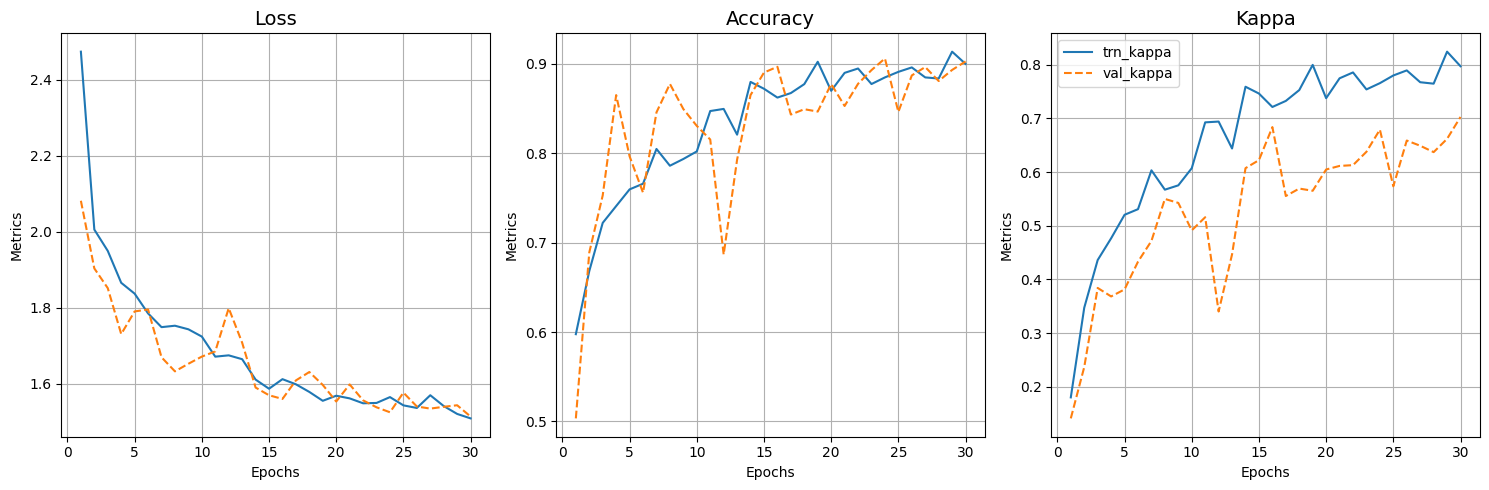

In [191]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
log.plot_epochs(['trn_loss', 'val_loss'], ax=axes[0])
axes[0].set_title('Loss', fontsize=14)

# plot accuracy
log.plot_epochs(['trn_acc', 'val_acc'], ax=axes[1])
axes[1].set_title('Accuracy', fontsize=14)

# plot kappa
log.plot_epochs(['trn_kappa', 'val_kappa'], ax=axes[2])
axes[2].set_title('Kappa', fontsize=14)

plt.tight_layout()
plt.show()

### Evaluate model

In [192]:
all_results = []
trained_logs = {}
trained_models = {}

In [193]:
# Test defined in larvae_utils.py
model = model_res
model_name = 'Residual'
(loss, acc, kappa) = Test(model, testload, criterion, device)

results_res = {
    'model': model_name,
    'test_loss': loss,
    'test_accuracy': acc,
    'test_kappa': kappa,
    'training_time': training_time,
    'total_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

all_results.append(results_res)
trained_logs[model_name] = log
trained_models[model_name] = model

In [194]:
# DataFrame with all results # seguir com esseeee
df_results = pd.DataFrame(all_results)
df_results.sort_values(by='test_accuracy', ascending=False, inplace=True)

print("===== COMPARE RESULTS =====")
print(df_results.round(4))

===== COMPARE RESULTS =====
      model  test_loss  test_accuracy  test_kappa  training_time  \
0  Residual     1.5565         0.8896      0.6338       655.1437   

   total_parameters  
0          51596098  


## Blocos de Incepção

In [195]:
# Bloco Inception simples para capturar features multi-escala
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        
        # Redução de dimensionalidade
        # in_channels = 256, out_channels = 64
        self.reduce_1x1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        
        # Branch 1: 1x1 conv
        # in_channels = 64, out_channels = 16
        self.branch1 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=1)
        
        # Branch 2: 1x1 + 3x3 conv
        # in_channels = 64, out_channels = 16
        self.branch2 = nn.Sequential(
            nn.Conv2d(out_channels//4, out_channels//4, kernel_size=1),
            nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, padding=1)
        )
        
        # Branch 3: 1x1 + 5x5 conv
        # in_channels = 64, out_channels = 16
        self.branch3 = nn.Sequential(
            nn.Conv2d(out_channels//4, out_channels//4, kernel_size=1),
            nn.Conv2d(out_channels//4, out_channels//4, kernel_size=5, padding=2)
        )
        
        # Branch 4: 3x3 maxpool + 1x1 conv
        # in_channels = 64, out_channels = 16
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        )
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_reduced = self.reduce_1x1(x)
        
        branch1 = self.branch1(x_reduced)
        branch2 = self.branch2(x_reduced)
        branch3 = self.branch3(x_reduced)
        branch4 = self.branch4(x)
        
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        outputs = self.bn(outputs)
        outputs = self.relu(outputs)
        
        return outputs
    
def inception_conv_block(nchannels_in, nchannels_out, stride_val):
    """Bloco inception com pooling"""
    return nn.Sequential(
        InceptionBlock(nchannels_in, nchannels_out),
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

In [196]:
# LarvaeNet com bloco residual no início + inception em sequencia
class LarvaeNetInception(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LarvaeNetInception, self).__init__()

        # Bloco residual inicial que projeta de 3 canais para 32 canais
        self.residual = nn.Sequential(
            residual_conv_block(input_shape[0], 32, stride_val=2)
        )

        # Blocos de Inception
        self.inception = nn.Sequential(
            inception_conv_block(32, 256, 2) # 32 canais de entrada, 256 canais de saída, stride=2
        )

        # Blocos convolucionais normais
        self.features = nn.Sequential(
            conv_block(256, 128, 2) # 32 canais de entrada, 128 canais de saída, stride=2
        )

        # uso de stride = 2 para reduzir a dimensão espacial pela metade

        # Classificador
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1]//8*input_shape[2]//8*128, # 8 = 2*2*2 max pooling (de cada bloco) / 128 = canais de saida do ultimo bloco conv
                out_features=64, 
                bias=True
            ),
            nn.Dropout(0.30),
            nn.ReLU(),
            nn.Linear(64, num_classes) 
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.residual(x)  # 3 > 32 canais
        x = self.inception(x) # 32 > 256 canais
        x = self.features(x)  # 256 > 128 canais
        x = torch.flatten(x, start_dim=1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

### Create model, define optimizer and scheduler

In [197]:
# create model  
model_inc = LarvaeNetInception(input_shape, nclasses).to(device)

# define optimizer and scheduler
optimizer = optim.Adam(model_inc.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

# clean up memory if needed
gc.collect()
torch.mps.empty_cache()

summary(model_inc)

Layer (type:depth-idx)                        Param #
LarvaeNetInception                            --
├─Sequential: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─ResidualBlock: 3-1                10,368
│    │    └─MaxPool2d: 3-2                    --
├─Sequential: 1-2                             --
│    └─Sequential: 2-2                        --
│    │    └─InceptionBlock: 3-3               156,608
│    │    └─MaxPool2d: 3-4                    --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─Conv2d: 3-5                       819,200
│    │    └─BatchNorm2d: 3-6                  256
│    │    └─ReLU: 3-7                         --
│    │    └─MaxPool2d: 3-8                    --
├─Sequential: 1-4                             --
│    └─Linear: 2-4                            6,422,592
│    └─Dropout: 2-5                           --
│    └─ReLU: 2-6                          

### Train the model and get results

In [198]:
# initializing variables
n_epochs = 30
log = Report(n_epochs)
model = model_inc.to(device)  # moving model to device
early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # early stopping

# starting training and validation
start_time = time.time()
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc, kappa = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, trn_kappa=kappa, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc, kappa = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, val_kappa=kappa, end='\r')

    if (ex+1) % 10 == 0: 
        log.report_avgs(ex+1)

    # count epochs for auto-adjusting the learning rate
    lr_scheduler.step()  # lr decay

    # early stopping
    epoch_val_acc = np.mean(log.val_acc)  # mean accuracy for the epoch
    early_stopping(epoch_val_acc)
    if early_stopping.early_stop:
        print("Early stopping at epoch", ex+1)
        break

training_time = time.time() - start_time

EPOCH: 10.000  val_kappa: 0.844  val_acc: 0.953  trn_kappa: 0.895  trn_acc: 0.949  val_loss: 1.939  trn_loss: 1.944  (265.82s - 531.64s remaining)
EPOCH: 20.000  val_kappa: 0.912  val_acc: 0.981  trn_kappa: 0.949  trn_acc: 0.975  val_loss: 1.862  trn_loss: 1.847  (531.83s - 265.91s remaining)
EPOCH: 30.000  val_kappa: 0.895  val_acc: 0.972  trn_kappa: 0.964  trn_acc: 0.982  val_loss: 1.843  trn_loss: 1.808  (801.49s - 0.00s remaining)


100%|██████████| 131/131 [00:00<00:00, 14978.43it/s]


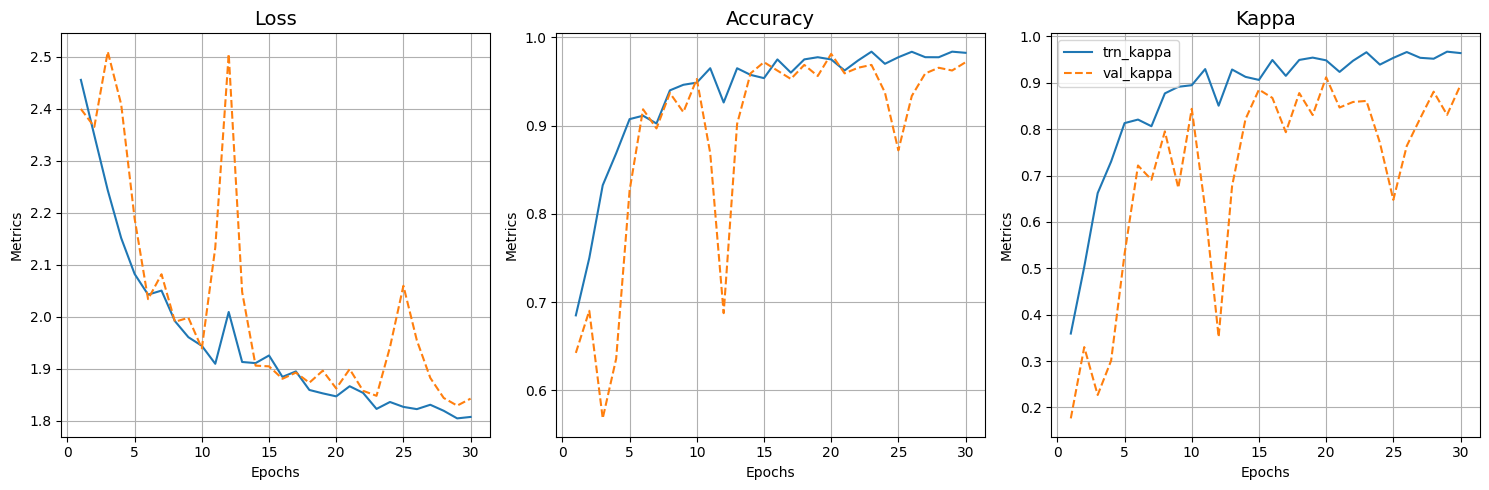

In [199]:
# plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
log.plot_epochs(['trn_loss', 'val_loss'], ax=axes[0])
axes[0].set_title('Loss', fontsize=14)

# plot accuracy
log.plot_epochs(['trn_acc', 'val_acc'], ax=axes[1])
axes[1].set_title('Accuracy', fontsize=14)

# plot kappa
log.plot_epochs(['trn_kappa', 'val_kappa'], ax=axes[2])
axes[2].set_title('Kappa', fontsize=14)

plt.tight_layout()
plt.show()

In [200]:
# evaluate model
model = model_inc
model_name = 'Residual+Inception'
(loss, acc, kappa) = Test(model, testload, criterion, device)

results_res = {
    'model': model_name,
    'test_loss': loss,
    'test_accuracy': acc,
    'test_kappa': kappa,
    'training_time': training_time,
    'total_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

all_results.append(results_res)
trained_logs[model_name] = log
trained_models[model_name] = model

In [201]:
# DataFrame with all results
df_results = pd.DataFrame(all_results)
df_results.sort_values(by='test_accuracy', ascending=False, inplace=True)

print("===== COMPARE RESULTS =====")
print(df_results.round(4))

===== COMPARE RESULTS =====
                model  test_loss  test_accuracy  test_kappa  training_time  \
1  Residual+Inception     1.8830         0.9625      0.8516       801.4936   
0            Residual     1.5565         0.8896      0.6338       655.1437   

   total_parameters  
1           7409154  
0          51596098  


## Blocos de Atenção

In [219]:
# Squeeze-and-Excitation (SE) Module
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        # global average pooling
        self.squeeze = nn.AdaptiveAvgPool2d(1) 
        self.excitation = nn.Sequential(
            # dense + relu
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            # dense + sigmoid
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: Global Average Pooling
        y = self.squeeze(x).view(b, c)
        # Excitation: FC layers + Sigmoid
        y = self.excitation(y).view(b, c, 1, 1)
        # Scale: Multiply attention weights
        return x * y.expand_as(x)
    
def conv_block_with_se(nchannels_in, nchannels_out, stride_val, reduction=16):
    """Bloco convolucional com SE"""
    return nn.Sequential(
        nn.Conv2d(
            in_channels=nchannels_in, 
            out_channels=nchannels_out, 
            kernel_size=(5, 5),
            stride=1, 
            padding=2, 
            bias=False
        ),
        nn.BatchNorm2d(num_features=nchannels_out),
        nn.ReLU(),
        SEBlock(nchannels_out, reduction), # SE module
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

In [220]:
# LarvaeNet com bloco de atenção
class LarvaeNetAttention(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LarvaeNetAttention, self).__init__()

        # Bloco residual inicial que projeta de 3 canais para 32 canais
        self.residual = nn.Sequential(
            residual_conv_block(input_shape[0], 32, stride_val=2)
        )

        # Blocos de Inception 
        self.inception = nn.Sequential(
            inception_conv_block(32, 256, 2) # 32 canais de entrada, 256 canais de saída, stride=2
        )

        # Blocos de atenção 
        self.atention = nn.Sequential(
            conv_block_with_se(256, 128, 2, reduction=16) # 32 canais de entrada, 256 canais de saída, stride=2
        )

        # Classificador
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1]//8*input_shape[2]//8*128, # 8 = 2*2*2 max pooling (de cada bloco) / 128 = canais de saida do ultimo bloco conv
                out_features=64, 
                bias=True
            ),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(64, num_classes) 
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.residual(x)
        x = self.inception(x)
        x = self.atention(x)
        x = torch.flatten(x, start_dim=1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

### Create model, define optimizer and scheduler

In [221]:
# create model  
model_att = LarvaeNetAttention(input_shape, nclasses).to(device)

# define optimizer and scheduler
optimizer = optim.Adam(model_att.parameters(), lr=2e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# clean up memory if needed
gc.collect()
torch.mps.empty_cache()

summary(model_att)

Layer (type:depth-idx)                        Param #
LarvaeNetAttention                            --
├─Sequential: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─ResidualBlock: 3-1                10,368
│    │    └─MaxPool2d: 3-2                    --
├─Sequential: 1-2                             --
│    └─Sequential: 2-2                        --
│    │    └─InceptionBlock: 3-3               156,608
│    │    └─MaxPool2d: 3-4                    --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─Conv2d: 3-5                       819,200
│    │    └─BatchNorm2d: 3-6                  256
│    │    └─ReLU: 3-7                         --
│    │    └─SEBlock: 3-8                      2,048
│    │    └─MaxPool2d: 3-9                    --
├─Sequential: 1-4                             --
│    └─Linear: 2-4                            6,422,592
│    └─Dropout: 2-5                    

### Train the model and get results

In [222]:
# modificando early stop
class EarlyStoppingKappa:
    def __init__(self, patience=5, min_delta=0.01, monitor='kappa'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc, val_kappa):
        # Usa Kappa como métrica principal (mais robusta para desbalanceamento)
        current_score = val_kappa if self.monitor == 'kappa' else val_acc
        
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

In [223]:
# initializing variables
n_epochs = 30
log = Report(n_epochs)
model = model_att.to(device)  # moving model to device
early_stopping = EarlyStoppingKappa(patience=7, min_delta=0.02, monitor='kappa')

# starting training and validation
start_time = time.time()
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc, kappa = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, trn_kappa=kappa, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc, kappa = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, val_kappa=kappa, end='\r')

    if (ex+1) % 10 == 0: 
        log.report_avgs(ex+1)

    # count epochs for auto-adjusting the learning rate
    lr_scheduler.step()  # lr decay

    # early stopping
    epoch_val_acc = np.mean(log.val_acc)  # mean kappa for the epoch
    epoch_val_kappa = np.mean(log.val_kappa)  # mean kappa for the epoch
    early_stopping(epoch_val_acc, epoch_val_kappa)
    if early_stopping.early_stop:
        print("Early stopping at epoch", ex+1)
        break

training_time = time.time() - start_time

EPOCH: 10.000  val_kappa: 0.824  val_acc: 0.959  trn_kappa: 0.920  trn_acc: 0.960  val_loss: 1.893  trn_loss: 1.868  (239.06s - 478.11s remaining)
EPOCH: 20.000  val_kappa: 0.917  val_acc: 0.975  trn_kappa: 0.910  trn_acc: 0.956  val_loss: 1.809  trn_loss: 1.829  (473.06s - 236.53s remaining)
EPOCH: 30.000  val_kappa: 0.908  val_acc: 0.975  trn_kappa: 0.961  trn_acc: 0.981  val_loss: 1.799  trn_loss: 1.783  (713.16s - 0.00s remaining)


100%|██████████| 131/131 [00:00<00:00, 21068.01it/s]


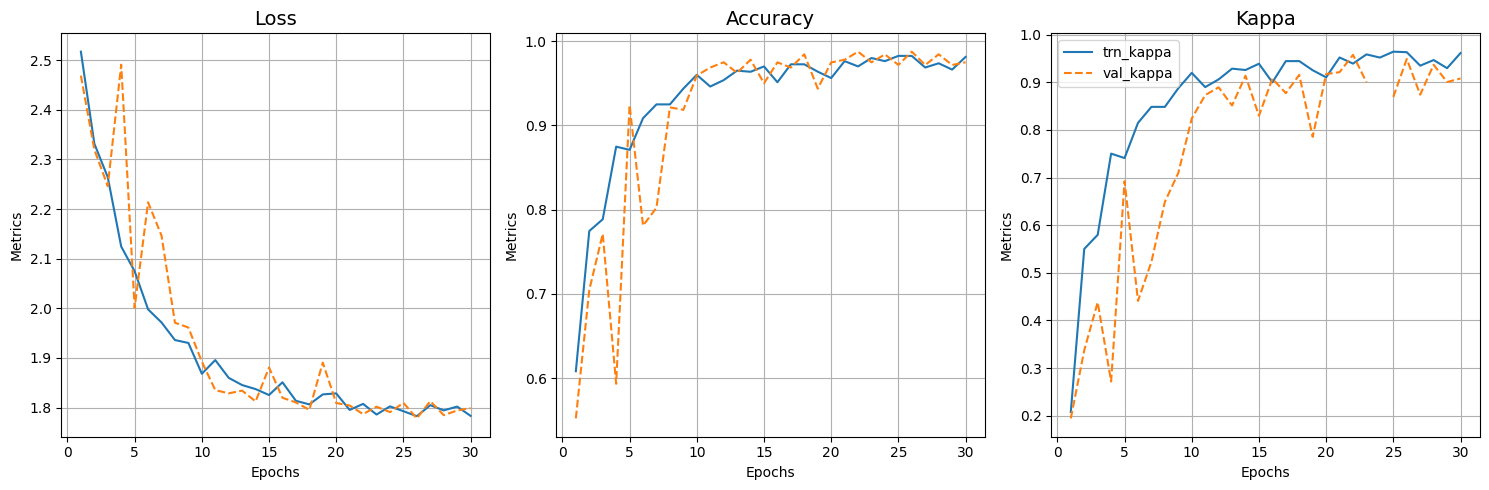

In [224]:
# plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
log.plot_epochs(['trn_loss', 'val_loss'], ax=axes[0])
axes[0].set_title('Loss', fontsize=14)

# plot accuracy
log.plot_epochs(['trn_acc', 'val_acc'], ax=axes[1])
axes[1].set_title('Accuracy', fontsize=14)

# plot kappa
log.plot_epochs(['trn_kappa', 'val_kappa'], ax=axes[2])
axes[2].set_title('Kappa', fontsize=14)

plt.tight_layout()
plt.show()

In [236]:
# evaluate model
model = model_att
model_name = 'Residual+Inception+SE'
(loss, acc, kappa) = Test(model, testload, criterion, device)

results_res = {
    'model': model_name,
    'test_loss': loss,
    'test_accuracy': acc,
    'test_kappa': kappa,
    'training_time': training_time,
    'total_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

all_results.append(results_res)
trained_logs[model_name] = log
trained_models[model_name] = model

In [235]:
all_results = [{'model': 'Residual',
  'test_loss': 1.5564576387405396,
  'test_accuracy': 0.8895833333333333,
  'test_kappa': np.float64(0.6338420783285699),
  'training_time': 655.1437349319458,
  'total_parameters': 51596098},
 {'model': 'Residual+Inception',
  'test_loss': 1.8830316225687662,
  'test_accuracy': 0.9625,
  'test_kappa': np.float64(0.8515522719952634),
  'training_time': 801.4935829639435,
  'total_parameters': 7409154}]

In [237]:
# DataFrame with all results
df_results = pd.DataFrame(all_results)
df_results.sort_values(by='test_accuracy', ascending=False, inplace=True)

print("===== COMPARE RESULTS =====")
print(df_results.round(4))

===== COMPARE RESULTS =====
                   model  test_loss  test_accuracy  test_kappa  training_time  \
2  Residual+Inception+SE     1.8368         0.9688      0.8753       713.1612   
1     Residual+Inception     1.8830         0.9625      0.8516       801.4936   
0               Residual     1.5565         0.8896      0.6338       655.1437   

   total_parameters  
2           7411202  
1           7409154  
0          51596098  


In [238]:
df_results

,model,test_loss,test_accuracy,test_kappa,training_time,total_parameters
2,Residual+Inception+SE,1.836819,0.968750,0.875339,713.161165,7411202
1,Residual+Inception,1.883032,0.962500,0.851552,801.493583,7409154
0,Residual,1.556458,0.889583,0.633842,655.143735,51596098


In [239]:
# save trained models
for model_name, model in trained_models.items():
    torch.save(model.state_dict(), f'trained_models2/{model_name}.pth')

## Get baseline model metrics

In [240]:
# DataFrame with all results
all_results.append(results_loaded) # results from the baseline model
df_results = pd.DataFrame(all_results)
df_results.sort_values(by='test_accuracy', ascending=False, inplace=True)

print("===== COMPARE RESULTS =====")
print(df_results.round(4))

===== COMPARE RESULTS =====
                   model  test_loss  test_accuracy  test_kappa  training_time  \
2  Residual+Inception+SE     1.8368         0.9688      0.8753       713.1612   
1     Residual+Inception     1.8830         0.9625      0.8516       801.4936   
0               Residual     1.5565         0.8896      0.6338       655.1437   
3               Baseline     1.3620         0.8375      0.5064       491.0481   

   total_parameters  
2           7411202  
1           7409154  
0          51596098  
3          51588194  


In [241]:
df_results

,model,test_loss,test_accuracy,test_kappa,training_time,total_parameters
2,Residual+Inception+SE,1.836819,0.968750,0.875339,713.161165,7411202
1,Residual+Inception,1.883032,0.962500,0.851552,801.493583,7409154
0,Residual,1.556458,0.889583,0.633842,655.143735,51596098
3,Baseline,1.362007,0.837500,0.506361,491.048076,51588194


In [242]:
# save all results
df_results.to_csv('trained_models2/results_scratch.csv', index=False)

In [244]:
df_results = pd.read_csv('trained_models2/results_scratch.csv')  # read results from csv file
df_results

,model,test_loss,test_accuracy,test_kappa,training_time,total_parameters
0,Residual+Inception+SE,1.836819,0.968750,0.875339,713.161165,7411202
1,Residual+Inception,1.883032,0.962500,0.851552,801.493583,7409154
2,Residual,1.556458,0.889583,0.633842,655.143735,51596098
3,Baseline,1.362007,0.837500,0.506361,491.048076,51588194


## Ordem Otimizada dos Blocos Arquiteturais

A arquitetura `LarvaeNetOptimized` segue as melhores práticas da literatura:

1. **RESIDUAL BLOCKS (Início)**
- **Posição**: Logo após a entrada
- **Função**: Estabilizar gradientes e facilitar treinamento
- **Benefício**: Permite redes mais profundas sem degradação

2. **INCEPTION BLOCKS (Meio)**
- **Posição**: Após features básicas serem extraídas
- **Função**: Capturar padrões em múltiplas escalas (1x1, 3x3, 5x5)
- **Benefício**: Melhor para objetos de tamanhos variados (larvas vs impurezas)

3. **ATTENTION BLOCKS (Final)**
- **Posição**: Antes do classificador
- **Função**: Focar nas regiões mais discriminativas
- **Benefício**: Melhora interpretabilidade e performance

4. **Arquitetura Geral**
```
Input (3, 224, 224)
    ↓
Residual (3→32) - Estabilização inicial
    ↓
Residual (32→64) + Pool - Features básicas
    ↓
Inception (64→128) + Pool - Multi-escala
    ↓
Inception (128→256) + Pool - Multi-escala refinada
    ↓
CBAM Attention (256) - Foco nas regiões importantes
    ↓
Residual Final (256) - Refinamento
    ↓
Global Pool + Classifier - Decisão final
```

**Vantagens desta ordem:**
- Gradientes fluem melhor (Residual)
- Captura padrões multi-escala (Inception)
- Foca no que importa (Attention)
- Reduz overfitting (Global Pooling)

# Visualize Results

## Feature Maps

Mostra os mapas de ativação da última camada convolucional para uma imagem.

### For correct classificaction

In [245]:
trained_models.keys()

dict_keys(['Residual', 'Residual+Inception', 'Residual+Inception+SE'])

In [246]:
# larva classficada como larva
#print(validset_[idx]) # =2
# larva classificada como resto
#print(validset_[idx_error]) # =151
# resto classificado como resto
#print(validset_[idx_resto]) # =5
# resto classificado como larva
#print(validset_[idx_error_resto]) # =0

# indices do primeiro notebook
idx = 2
idx_error = 151
idx_resto = 5
idx_error_resto = 0

In [247]:
# Percorre validset_, salva o target correto, a predição do modelo e o índice
model = trained_models['Residual+Inception+SE']
model = model.to(device)
model.eval()
targets_true = []
preds_model = []
indices = []
img_paths = []

with torch.no_grad():
    for idx, (img, target) in enumerate(validset):
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
        targets_true.append(target)
        preds_model.append(pred)
        indices.append(idx)
        img_paths.append(validset_[idx])

# Criar DataFrame
df_preds = pd.DataFrame({
    'caminho_imagem': img_paths,
    'target_verdadeiro': targets_true,
    'predicao': preds_model,
    'indice': indices
})

df_preds.head()

,caminho_imagem,target_verdadeiro,predicao,indice
0,../../figures-datasets/images/larvae/000002_00...,1,1,0
1,../../figures-datasets/images/larvae/000002_00...,1,1,1
2,../../figures-datasets/images/larvae/000001_00...,0,0,2
3,../../figures-datasets/images/larvae/000001_00...,0,0,3
4,../../figures-datasets/images/larvae/000002_00...,1,1,4


In [248]:
# indices do primeiro notebook
idx = 2
idx_error = 151
idx_resto = 5
idx_error_resto = 0

In [ ]:
df_preds[df_preds['indice'].isin([idx,idx_error,idx_resto,idx_error_resto])]
# todas passaram a ser classificadas corretamente menos 151
# 151 = larva predita como resto

,caminho_imagem,target_verdadeiro,predicao,indice
0,../../figures-datasets/images/larvae/000002_00...,1,1,0
2,../../figures-datasets/images/larvae/000001_00...,0,0,2
5,../../figures-datasets/images/larvae/000002_00...,1,1,5
151,../../figures-datasets/images/larvae/000001_00...,0,1,151


In [250]:
# idx é o índice do exemplo de classificação correta
image, target = validset[idx] # get idx th image from trainset
image.size() # it is a tensor with shape (nchannels, height, width)
image = image.unsqueeze(0) # add batch dimension

In [251]:
# extrair feature map da parte convolucional da rede 
def get_attention_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        # Pass through residual block first
        x = model.residual(input_tensor)  
        # Pass through inception block
        x = model.inception(x)           
        # pass through attention (this is what you want)
        feature_map = model.atention(x)  
        
    return feature_map

In [252]:
feature_map = get_attention_feature_map(model.to(device), image.to(device)) # get feature map from the first layer
feature_map.size() # it is a tensor with shape (batch_size, nchannels_out, height_out, width_out)

torch.Size([1, 128, 28, 28])

In [253]:
# salva os feature maps como imagem
# feature_map: tensor com os mapas de características extraídos para cada canal
save_feature_map_as_image(feature_map, 'feature_maps/attetion')  

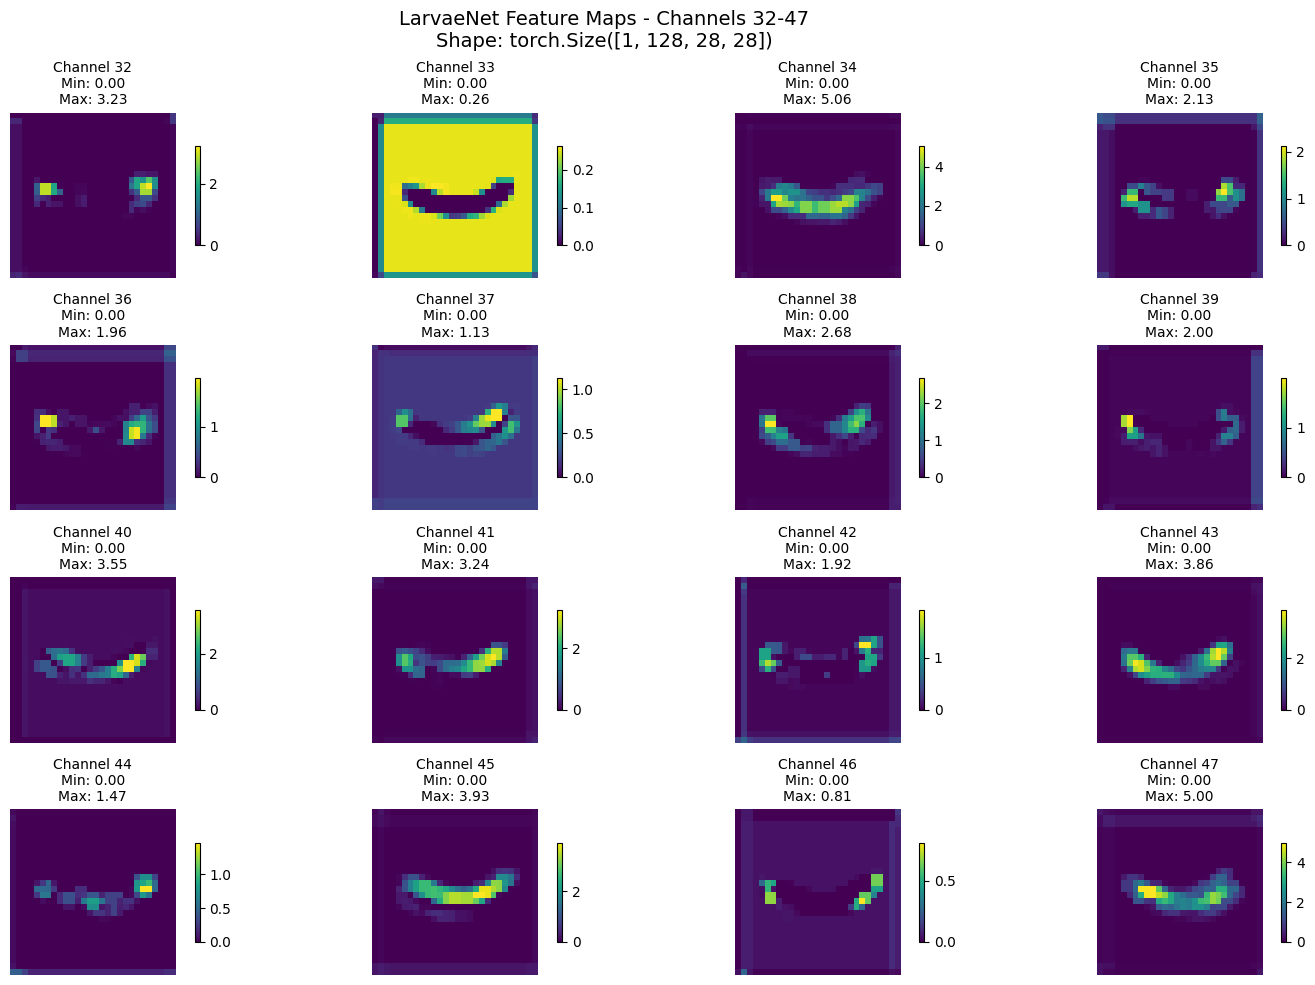

In [254]:
# visualize 16 canais a partir do canal 32
visualize_features(feature_map, max_channels=16, start_channel=32)  

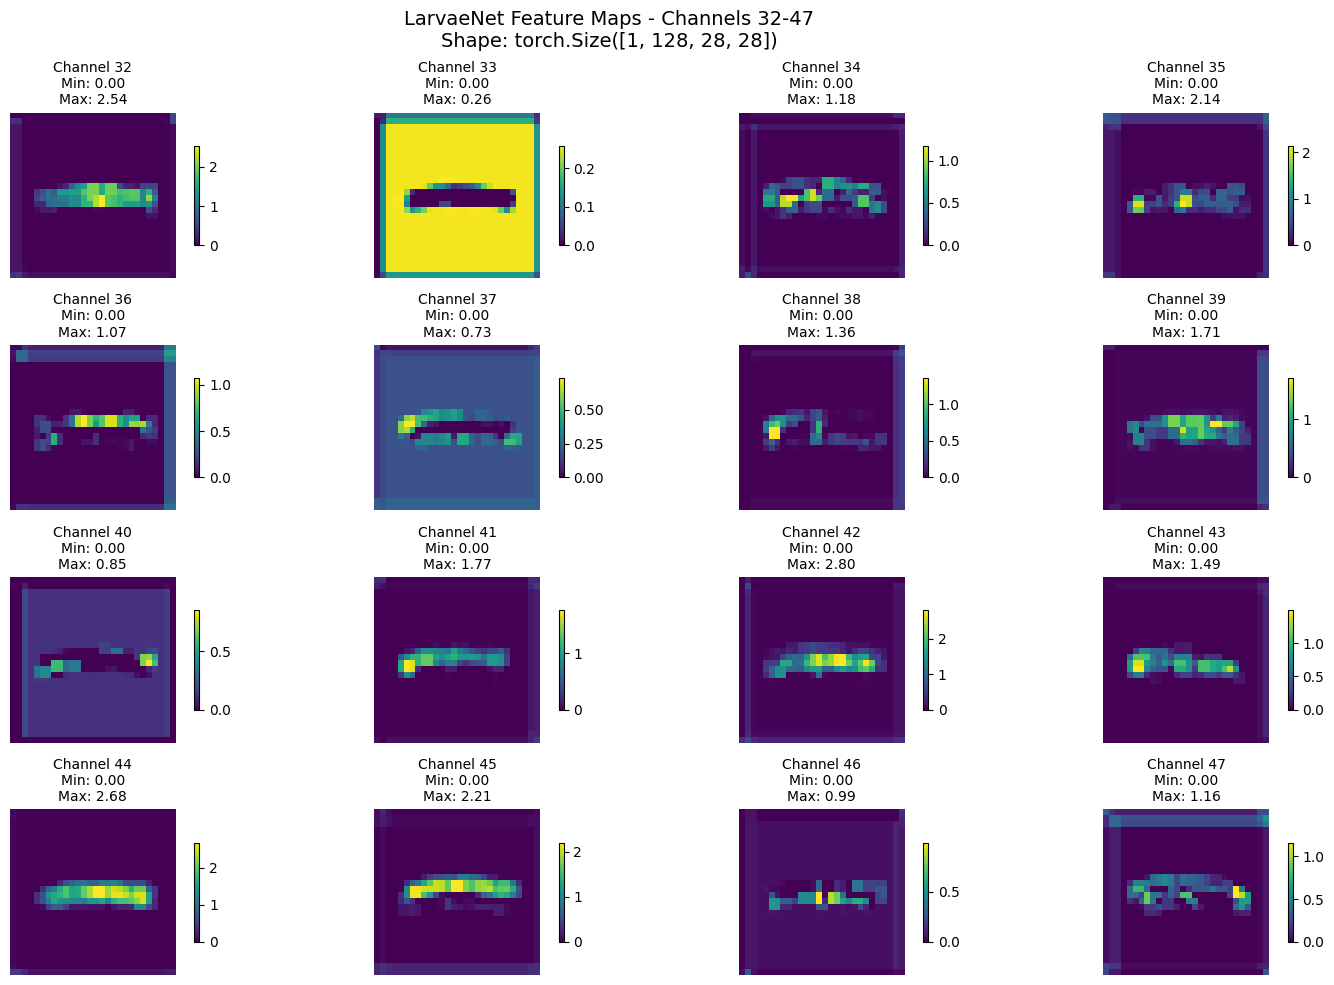

In [255]:
# idx é o índice do exemplo de classificação correta
image_resto, target_resto = validset[idx_resto] # get idx th image from trainset
image_resto.size() # it is a tensor with shape (nchannels, height, width)
image_resto = image_resto.unsqueeze(0) # add batch dimension

feature_map_resto = get_attention_feature_map(model, image_resto.to(device)) 
visualize_features(feature_map_resto, max_channels=16, start_channel=32)

### For uncorrect classification

In [256]:
# idx é o índice do exemplo de classificação incorreta
image_error, target_error = validset[idx_error] # get idx th image from trainset
image_error.size() # it is a tensor with shape (nchannels, height, width)
image_error = image_error.unsqueeze(0) # add batch dimension

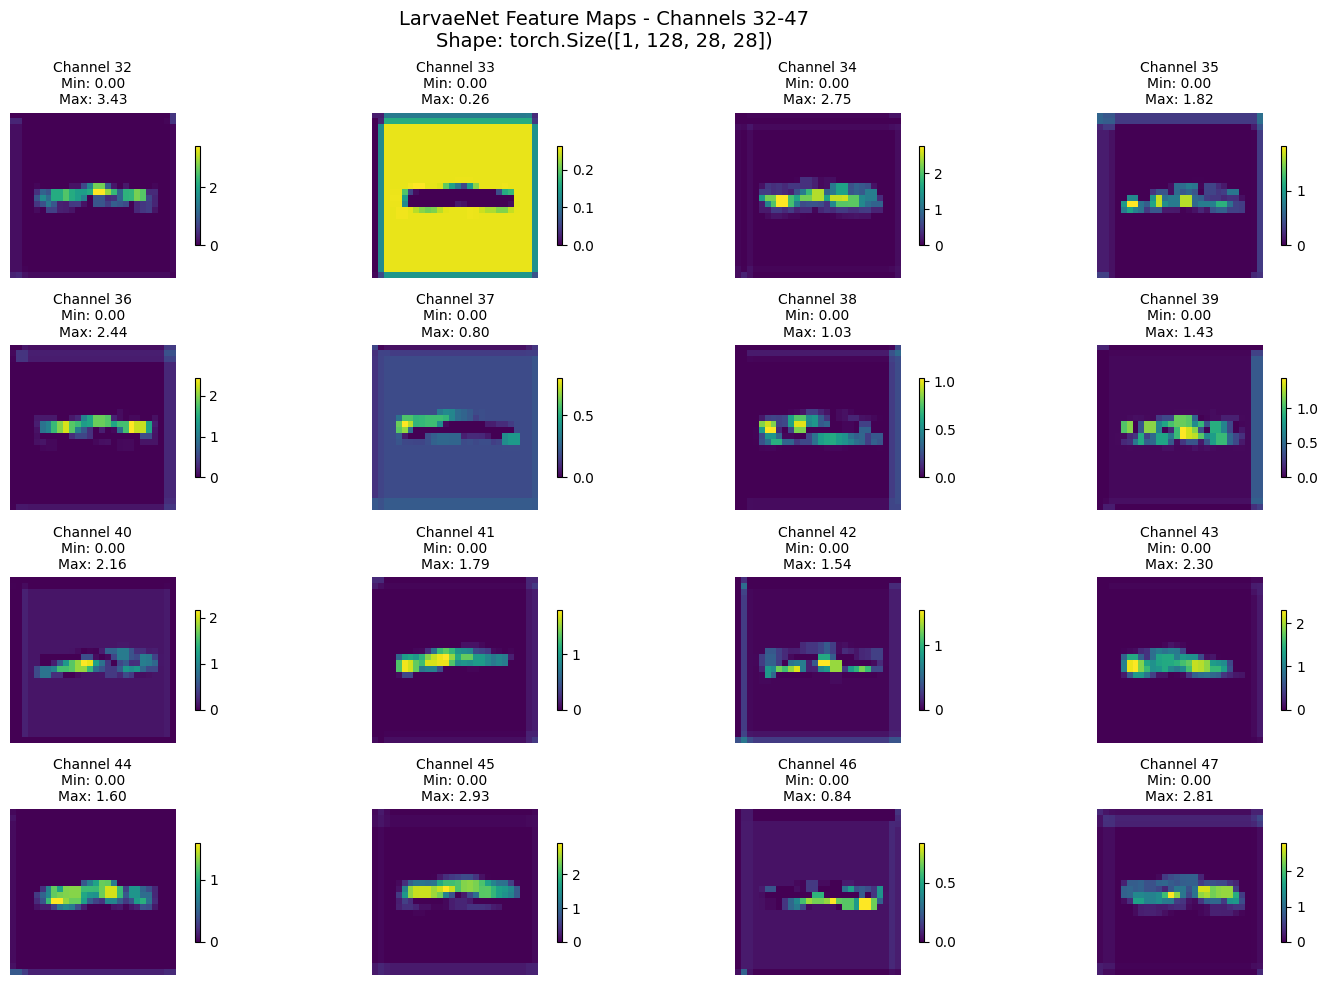

In [257]:
feature_map_error = get_attention_feature_map(model, image_error.to(device)) 
visualize_features(feature_map_error, max_channels=16, start_channel=32)

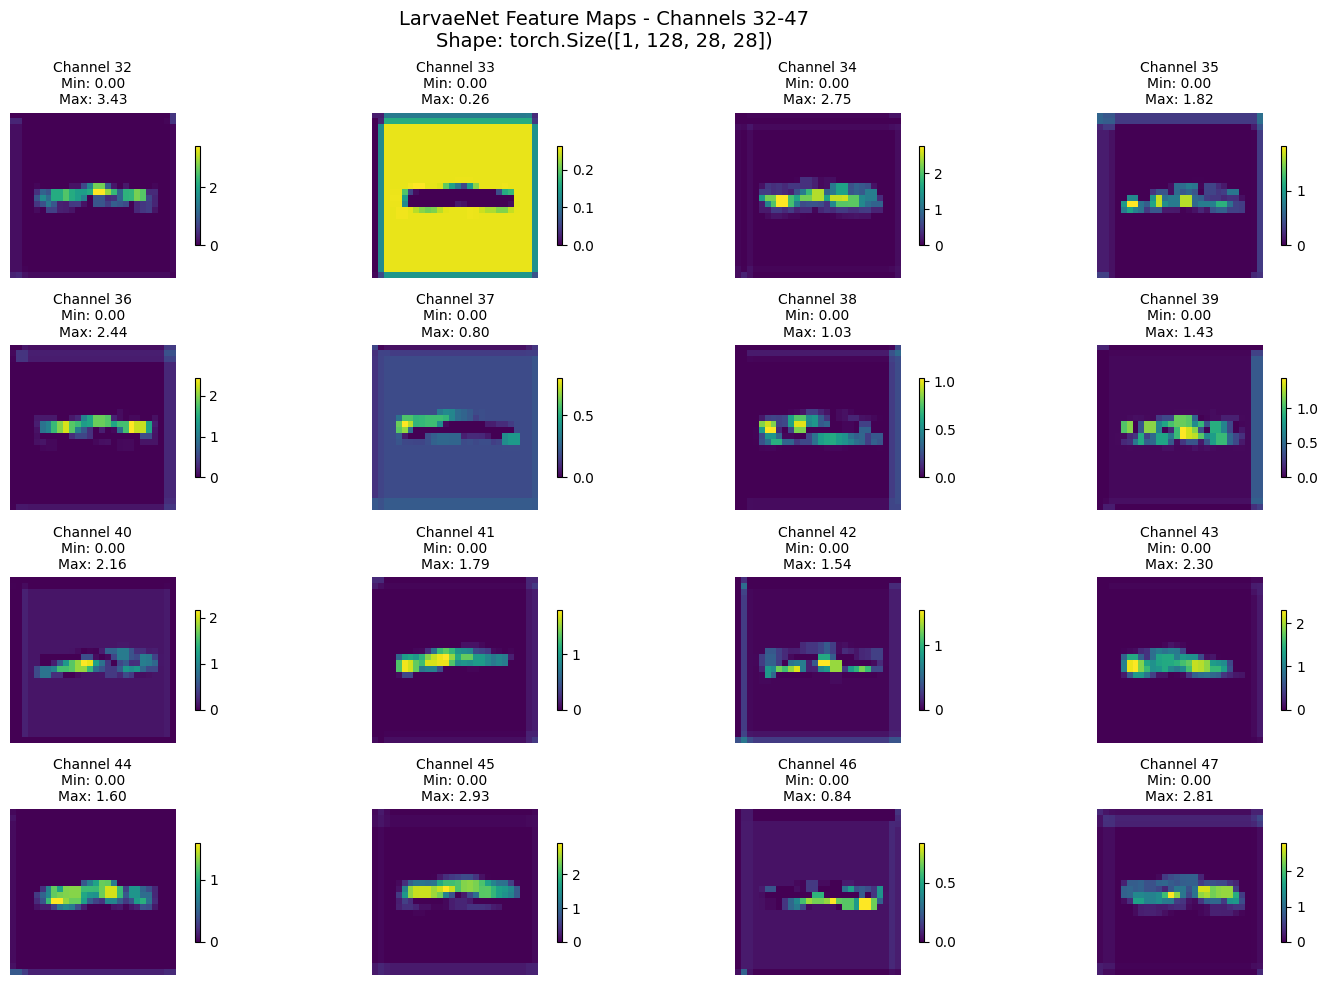

In [258]:
# idx é o índice do exemplo de classificação incorreta
image_error_resto, target_error_resto = validset[idx_error_resto] # get idx th image from trainset
image_error_resto.size() # it is a tensor with shape (nchannels, height, width)
image_error_resto = image_error_resto.unsqueeze(0) # add batch dimension

feature_map_error_resto = get_attention_feature_map(model, image_error.to(device)) 
visualize_features(feature_map_error_resto, max_channels=16, start_channel=32)

## Projeções Ativações

In [259]:
# function to get the output of each layer/block in convolutional neural network
from collections import OrderedDict
def get_each_output_attetion(model, x):
    #empty dict
    output_by_layer = OrderedDict()
  
    #get the input
    output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

    # for each layer of the residual block
    for layer_name, layer in model.residual.named_children():   
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["residual-"+layer_name] = x.clone().detach().cpu().numpy()

    # for each layer of the inception block
    for layer_name, layer in model.inception.named_children():   
        x = layer.forward(x)
        output_by_layer["inception-"+layer_name] = x.clone().detach().cpu().numpy()

    # for each layer of the attention block
    for layer_name, layer in model.atention.named_children():
        x = layer.forward(x)
        output_by_layer["features-"+layer_name] = x.clone().detach().cpu().numpy()

    x = torch.flatten(x, start_dim=1) # flatten the tensor
    output_by_layer['flattened'] = x.clone().detach().cpu().data.numpy()

    # for each layer of the classifier 
    for layer_name, layer in model.classifier.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()
  
    #return output by layer
    return output_by_layer

In [260]:
# impoet umap and t-sne
import umap.umap_ as umap
from sklearn.manifold import TSNE
from numpy import broadcast_to

In [261]:
# Função para pegar outputs e labels
def get_ouputs(model, dataload, device, get_outputs_function):
    outputs_by_layer = None
    all_labels = None

    #get a batch from the dataload
    for inputs, labels in dataload:
        #move inputs to the correct device
        inputs = inputs.to(device)
        labels = labels.clone().detach().cpu().numpy()

        #get the activations for visualization
        outputs = get_outputs_function(model, inputs) # one of the function's defined above

        #save the outputs
        if outputs_by_layer is None:
            outputs_by_layer = outputs
            all_labels       = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate((outputs_by_layer[layer], outputs[layer]), axis=0)
            all_labels = np.concatenate((all_labels, labels))   

    return outputs_by_layer, all_labels

# Função para projetar ativações em 2D
def projection(outputs_by_layer, reducer):
    projection_by_layer = OrderedDict()

    for layer in outputs_by_layer:
        #get the output of layer
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        #map to 2D
        embedded = reducer.fit_transform(output)
        #save projection
        projection_by_layer[layer] = embedded
  
    return projection_by_layer

In [262]:
# get the output of each layer
outputs_by_layer, all_labels = get_ouputs(model, validload, device, get_outputs_function=get_each_output_attetion)

# get tsne projection
reducer = TSNE(perplexity=30)
projection_by_layer_tsne = projection(outputs_by_layer, reducer)

# get umap projection
reducer = umap.UMAP()
projection_by_layer_umap = projection(outputs_by_layer, reducer)

In [263]:
# Funcão para visualizar projeções de ativações
from matplotlib.patches import Patch
def create_visualization(projection_by_layer_umap, projection_by_layer_tsne, all_labels, save_img=False, save_dict=None):
    
    colors = ['steelblue' if label == 0 else 'firebrick' for label in all_labels]
    
    for layer in projection_by_layer_umap:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # UMAP plot
        embedded = projection_by_layer_umap[layer]
        scatter1 = axes[0].scatter(embedded[:, 0], embedded[:, 1], c=colors, alpha=0.7)
        axes[0].set_title(f'{layer} - UMAP')
        
        # Criar legenda manual
        legend_elements = [Patch(facecolor='steelblue', label='Impurities (0)'),
                           Patch(facecolor='firebrick', label='Larvae (1)')]
        axes[0].legend(handles=legend_elements)
        
        # t-SNE plot  
        embedded2 = projection_by_layer_tsne[layer]
        scatter2 = axes[1].scatter(embedded2[:, 0], embedded2[:, 1], c=colors, alpha=0.7)
        axes[1].set_title(f'{layer} - t-SNE')
        axes[1].legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.show()
        plt.close(fig)

        if save_img:
            fig.savefig(f'{save_dict}/projection_{layer}.png', dpi=300, bbox_inches='tight')
            print(f"Saved projection_{layer}.png")

    return None

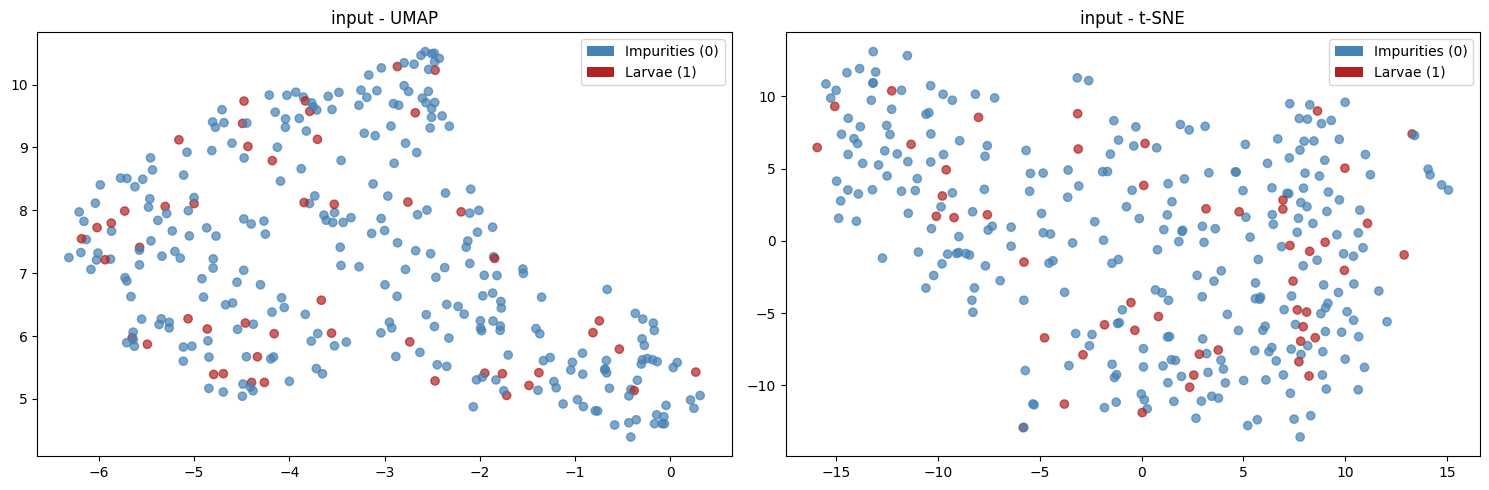

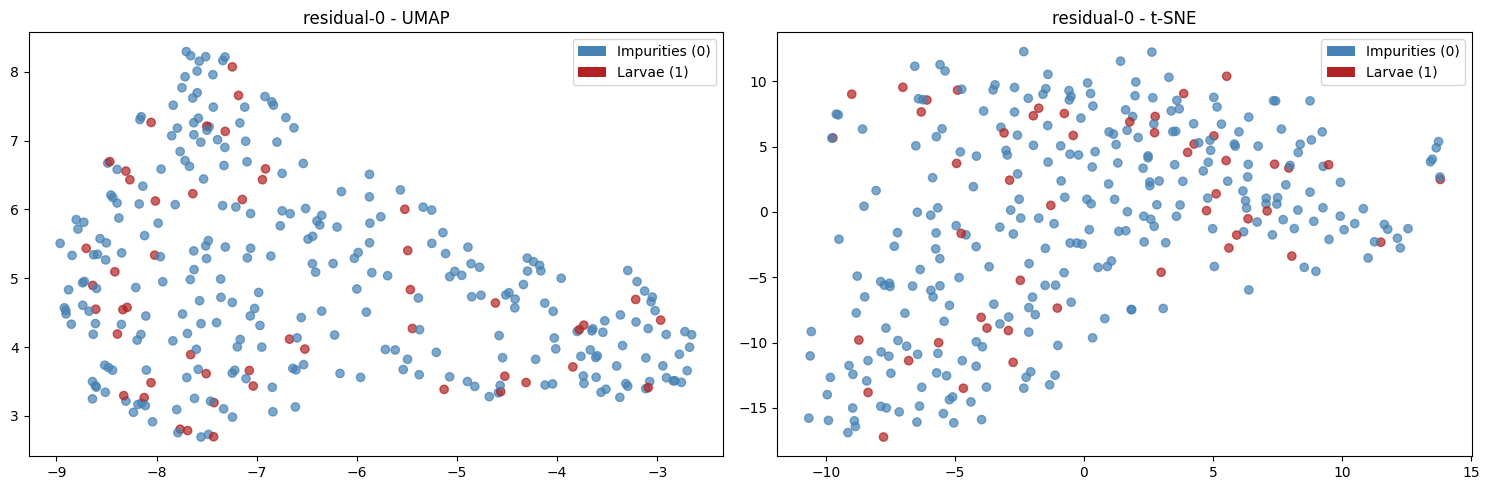

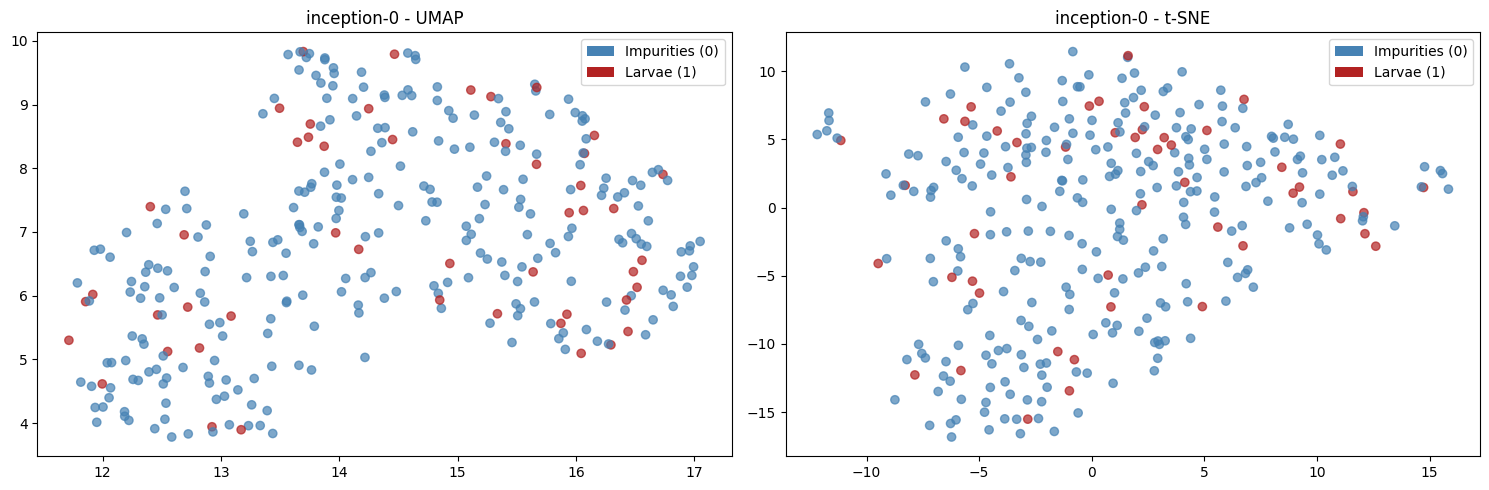

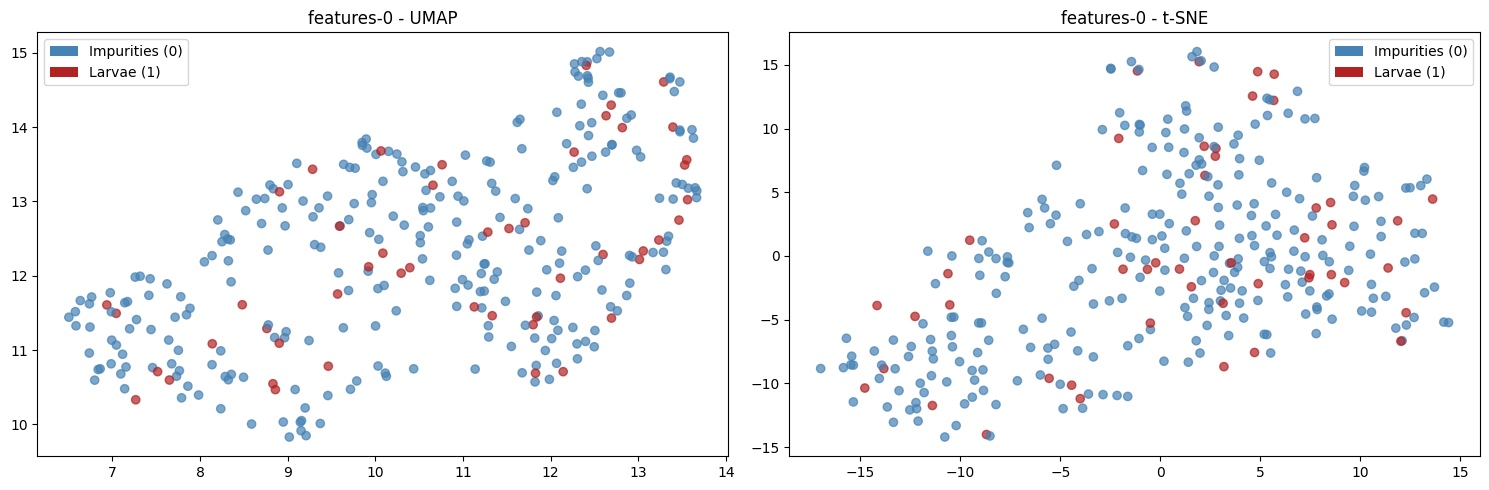

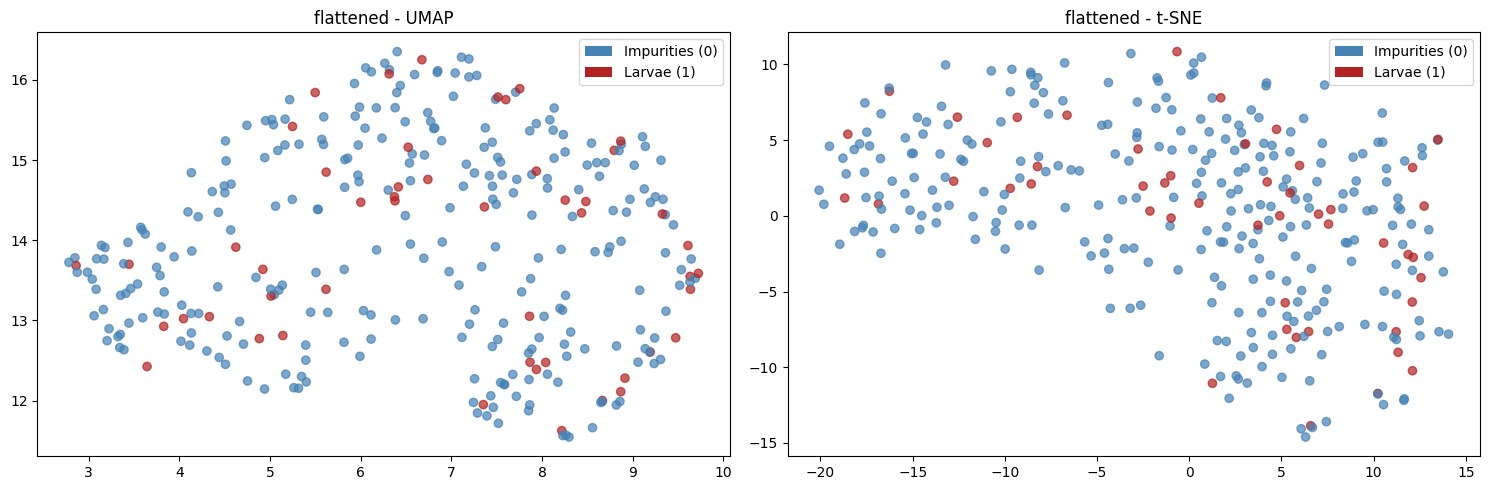

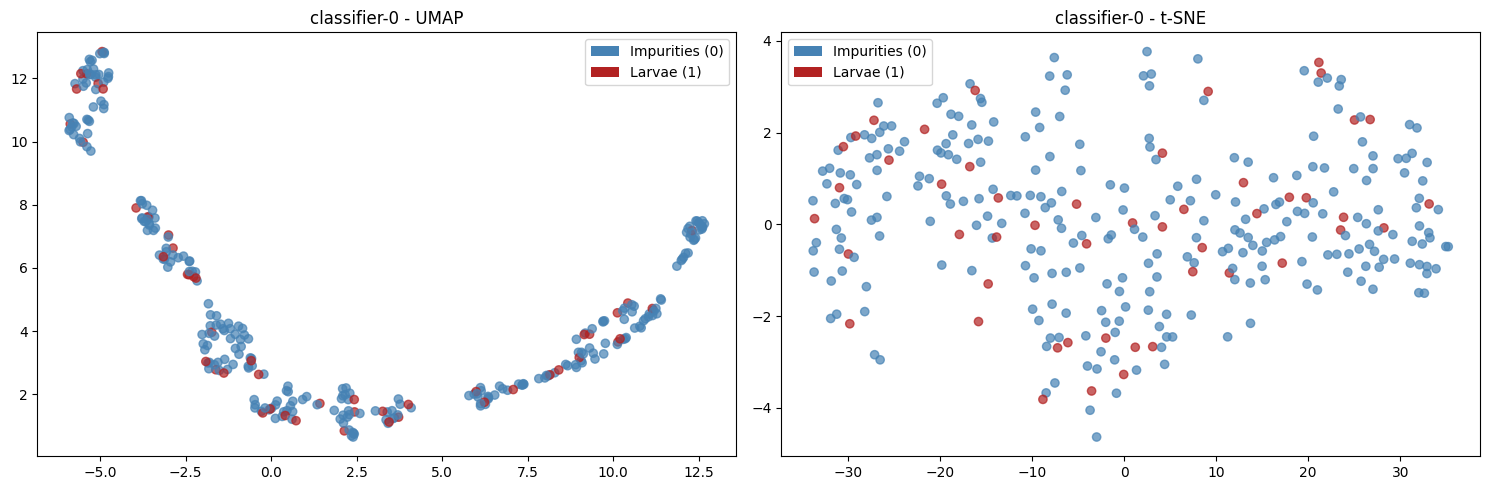

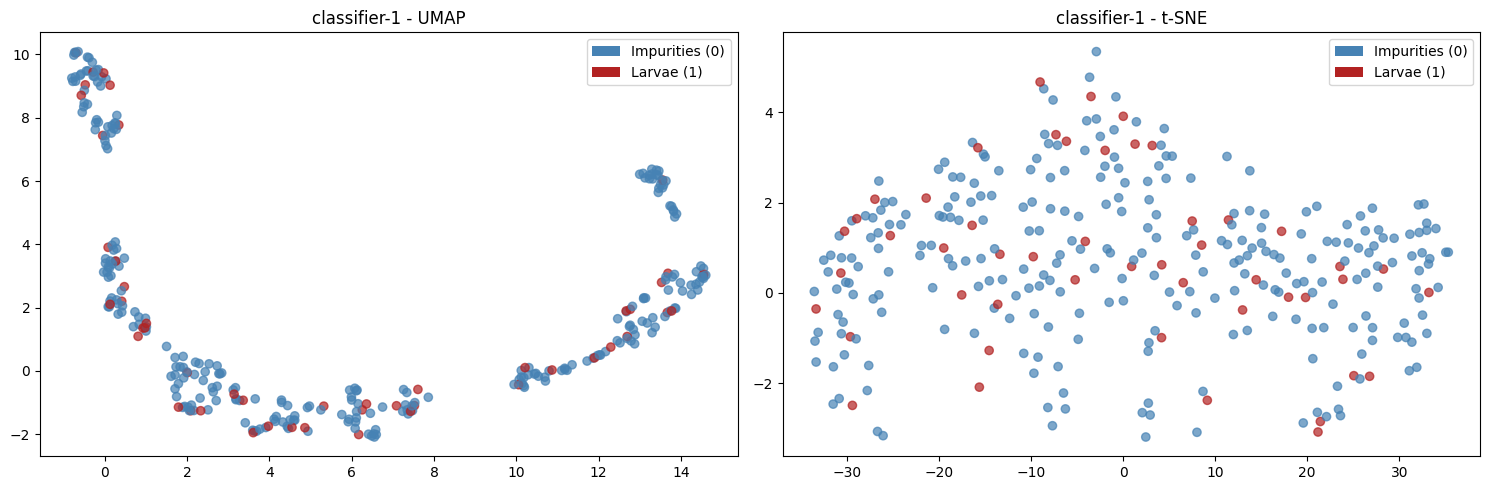

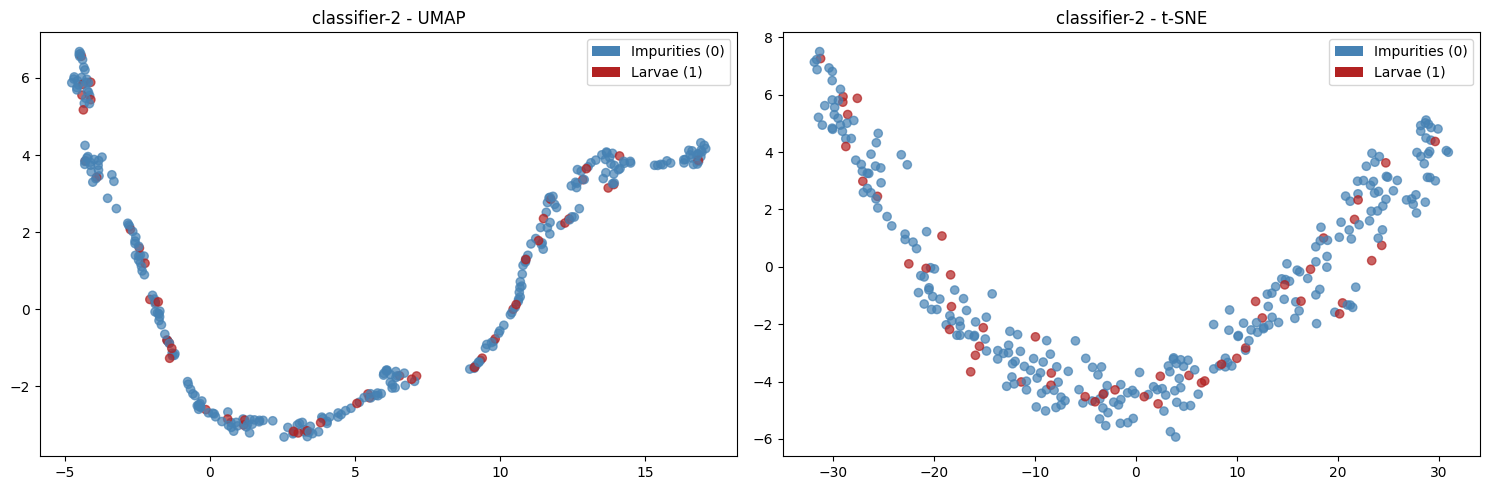

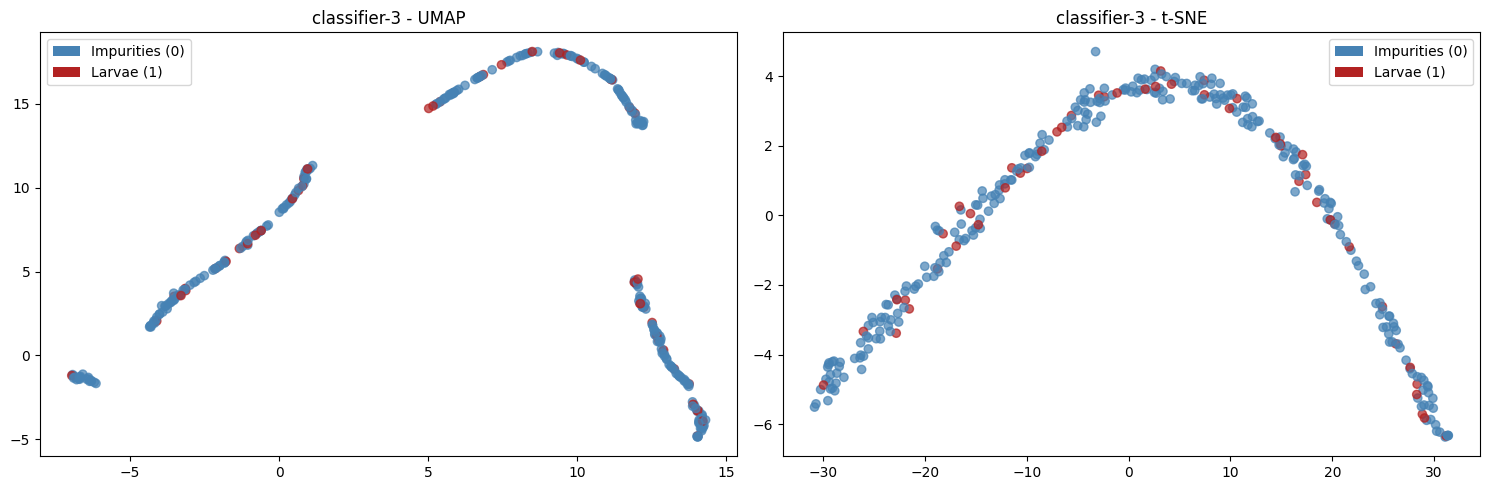

In [264]:
# visualize the projection of the output of each layer
create_visualization(projection_by_layer_umap, projection_by_layer_tsne, valid_labels)

## Regiões de Atenção (GradCAM)

Mostra regiões da imagem que mais influenciaram na decisão do modelo.

In [265]:
# Função para gerar GradCAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def generate_cam(self, input_image, class_idx=None):
        model_output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        self.model.zero_grad()
        class_score = model_output[:, class_idx]
        class_score.backward()
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(input_image.device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-8)
        return cam.detach().cpu().numpy()

# Função para gerar GradCAM para um modelo customizado
def gradcam_custom_model(model, image, target_layer_name):
    target_layer = dict(model.named_modules())[target_layer_name]
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate_cam(image)
    return cam

# Função para visualizar GradCAM
def visualize_gradcam(orig_image, cam, alpha=0.4):
    cam_resized = cv2.resize(cam, (orig_image.shape[1], orig_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = heatmap * alpha + orig_image * (1 - alpha)
    overlayed = 255*(overlayed - np.min(overlayed)) / (np.max(overlayed)-np.min(overlayed) + 1e-8)
    overlayed = overlayed.astype('uint8')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap)
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(overlayed.astype(np.uint8))
    axes[2].set_title('Overlayed Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

    return overlayed, heatmap


In [266]:
import torch.nn.functional as F
import cv2

conv2d_last_block = model.atention[0][4] # get SE block
for name, module in model.named_modules():
    if module is conv2d_last_block:
        target_layer_name = name
        break

# Generate GradCAM for 
# image = exemplo de classificação correta de larva
cam = gradcam_custom_model(model, image.to(device), target_layer_name)
# image_error = exemplo de classificação incorreta de larva
cam_error = gradcam_custom_model(model, image_error.to(device), target_layer_name)
# image_resto = exemplo de classificação correta de resto
cam_resto = gradcam_custom_model(model, image_resto.to(device), target_layer_name)
# image_error_resto = exemplo de classificação incorreta de resto
cam_error_resto = gradcam_custom_model(model, image_error_resto.to(device), target_layer_name)

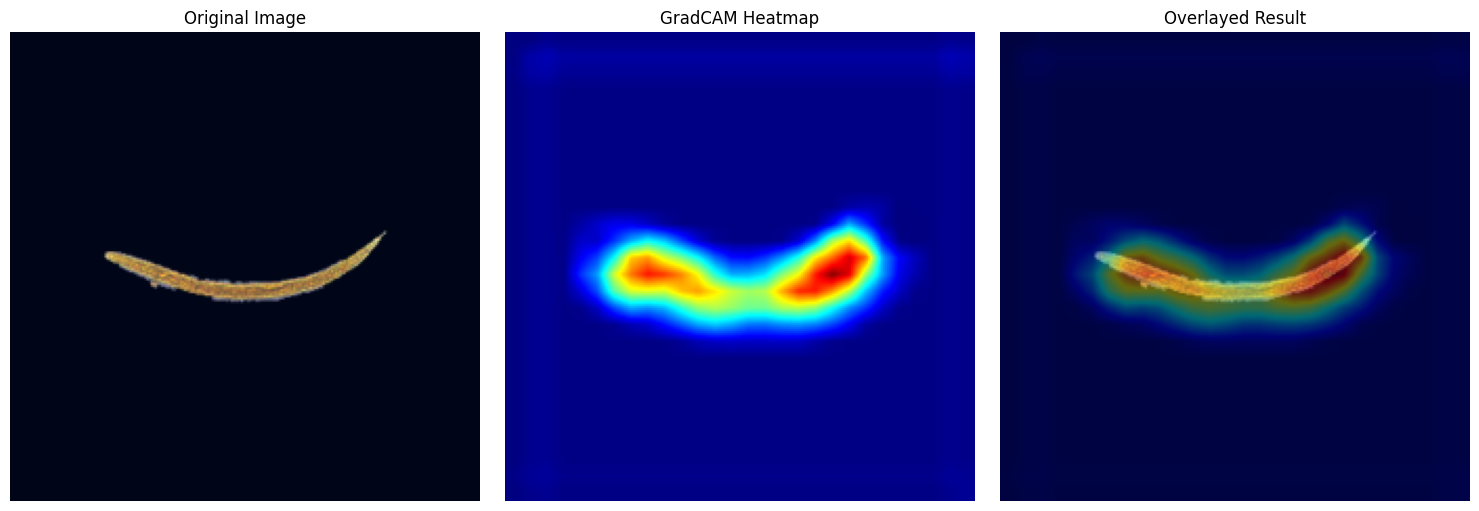

In [267]:
orig_image, target = validset[idx]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam, alpha=0.4)

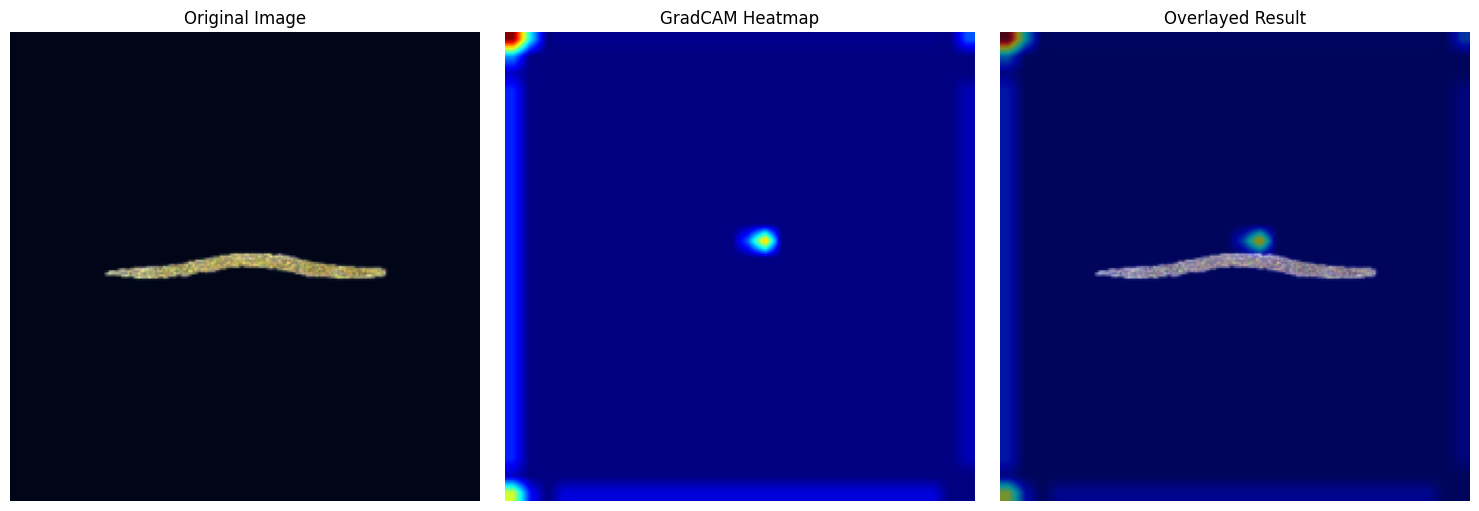

In [ ]:
# essa é a larva predita como resto, que continuou errando
# nao conseguiu capturar regiao de calor no corpo da larva
orig_image, target = validset[idx_error]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_error, alpha=0.4)

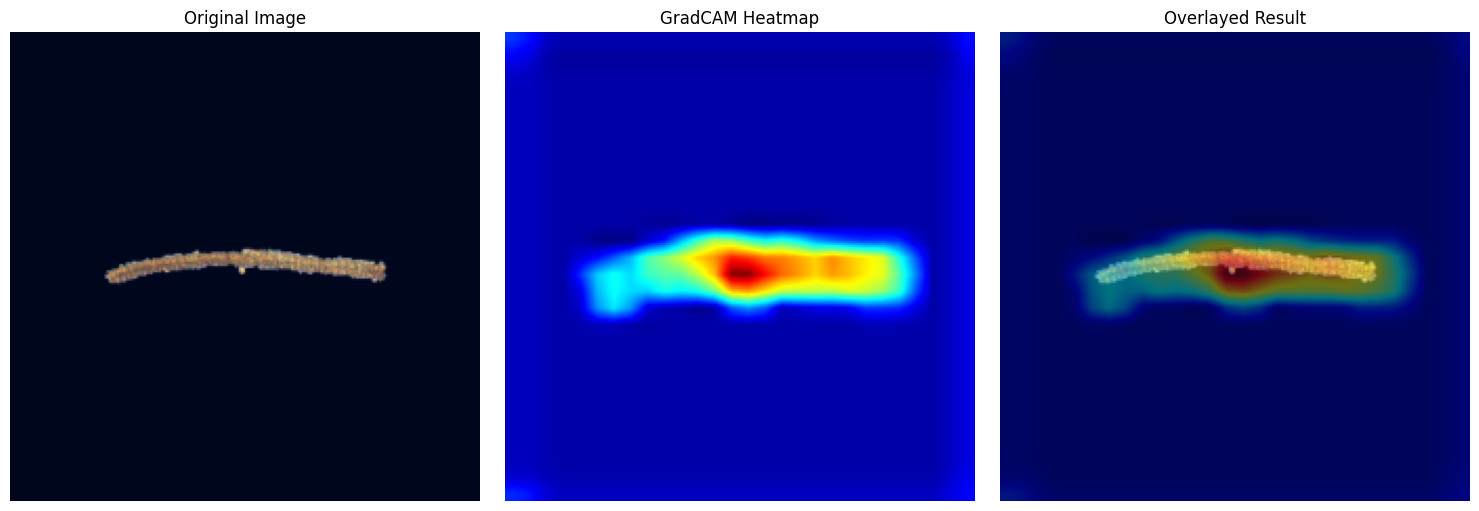

In [ ]:
# resto predito como resto nas duas redes
# 
orig_image, target = validset[idx_resto]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_resto, alpha=0.4)

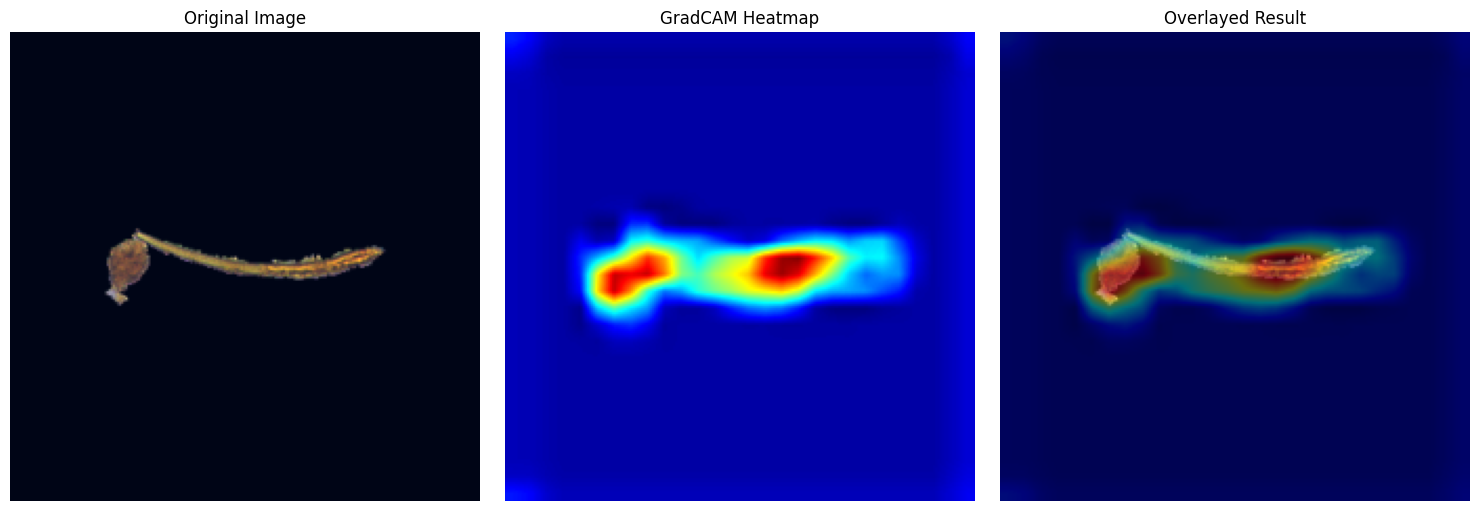

In [ ]:
# resto predito como larva no baseline
# porem aqui acerta a predicao
# parece que o modelo esta considerando larvas mais retas como restos, por isso confunde a 151
# quando tem um pouco de curva, o modelo consegue identificar a larva
orig_image, target = validset[idx_error_resto]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_error_resto, alpha=0.4)